# Draft notebook:  HEASARC access through python
This notebook goes through examples of how to access HEASARC data, whether catalogs, images, or spectra, using various VO protocols.  The services are described on the __[HEASARC VO](https://heasarc.gsfc.nasa.gov/docs/archive/vo/)__ page.

* [1. VOTable](#votable): Creating a VO table of objects to work with
* [2. SIA](#sia): Using the Simple Image Access protocol.  
* [3a. TAP1](#tap1): Using the Table Access Protocol to find available VO resources
* [3b. TAP2](#tap2): Using the TAP to cross-correlate our objects with a catalog
* [4. Combining](#combo) data from different catalogs
* [5. SCS](#scs):  Using the Simple Cone Search to query a different catalog in a loop
* [6. SSA](#ssa):  Using the Simple Spectral Access protocol to retrieve spectra.


## Notes:

There are a number of ways to use VO services through Python.  From the AstroQuery web page (https://astroquery.readthedocs.io/en/latest/):

<div class="alert alert-block alert-info">"There are two other packages with complimentary functionality as Astroquery: astropy.vo is in the Astropy core and pyvo is an Astropy affiliated package. They are more oriented to general virtual observatory discovery and queries, whereas Astroquery has web service specific interfaces."</div>
    
For this notebook, we will stick with the generic python requests method. In general, the queries are simple enough that this is almost as readable, and it has the benefit of depending on no specialized packages. There is as yet no single standardized set of Python tools for accessing VO data.  


In [57]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy
## There are a number of relatively unimportant warnings that 
## show up, so for now, suppress them:
import warnings
warnings.filterwarnings("ignore")
## The main HTTP request tool we will use:
import requests
## For simple astropy tables
import astropy
import io
from IPython.display import Image, display


## For handling VO table type objects
from astropy.io import votable as apvot
#from astropy.io.votable.tree import VOTableFile, Resource, Table, Field
## 
#import astropy.coordinates as coord
## For displaying images
## For reading FITS files
import astropy.io.fits as apfits

<a id="votable"></a>
# 1. VOTable:  Creating a VO Table of objects to work with


We can use W3Browse to get a HEASARC catalog as a VOTable object.  W3Browse can be used to retrieve tables in a number of formats, one of which is a VO Table.  

The requests package of python is a generic interface to web services.  The requests.get() method formats the given parameters for you and returns the results of the HTTP request in a useful object.  In this case, the result is a string containing the VOTable result.  We then use the python votable package to parse it and give us an object that works like an astropy Table.

In [2]:
params = {'name': 'rosmaster'}
r = requests.get('http://heasarc.gsfc.nasa.gov/cgi-bin/W3Browse/getvotable.pl', params=params)
#r.text

In [6]:
rosmaster_vot=apvot.parse( io.StringIO(r.text) )
table = rosmaster_vot.get_first_table()

In [7]:
print type(table)
table

<class 'astropy.io.votable.tree.Table'>


<Table masked=True length=11431>
    col1      col2     col3     col4     col5   ... col25 col26 col27 col28
              deg      deg      deg      deg    ...  deg    d     d        
   str16    float64  float64  float64  float64  ... int16 int32 int32 int16
----------- -------- -------- -------- -------- ... ----- ----- ----- -----
RH202299N00  49.3200 -85.5400 299.8517 -30.6815 ...   307  2163  2177  2900
RH202299A01  49.3200 -85.5400 299.8517 -30.6815 ...   162  2316  2369  2900
RP200594N00 151.8800 -85.0800 299.4192 -23.3707 ...    66   648   657  2900
RH201328N00 107.9100 -84.4700 296.7740 -26.5072 ...   215   850   851  2900
RH400876A01 193.9400 -83.3700 303.0651 -20.4994 ...   299  2699  2733  9999
RH400876N00 193.9400 -83.3700 303.0651 -20.4994 ...    85  2543  2543  9999
RH400877A02 190.1700 -83.3600 302.6001 -20.4952 ...    90  2893  2895  9999
RH400877A01 190.1700 -83.3600 302.6001 -20.4952 ...   260  2733  2733  9999
RH400877N00 190.1700 -83.3600 302.6001 -20.4952 ...    

Alternatively, we can create a table from scratch using an array of values named whatever we want.  There are a few object layers here, which can be confusing.  There are standard astropy Table objects, there are votable Table objects, and there are votable VOTableFile objects that might contain multiple votable Tables. Though some things can be done with only astropy Tables, other VO operations can only be done with VO Tables.  

This is easiest to see with an example:

<div class="alert alert-block alert-danger">
Can this be simplified?  Why do we really need the VOTableFile level with only one table?  Because we read-write to disk?  Can that be avoided?</div>

In [77]:
##  Create a table with only two columns starting from an astropy Table:  
from astropy.table import Table as apTable
aptable=apTable(
    numpy.array([
            [19.0186,       46.7304],
            [20.2887,       40.4703],
            [125.886,       21.3377],
            [136.002,       21.9679],
            [141.057,       40.6372],
            [146.700,       22.0116],
            [148.785,       14.2922],
            [149.751,       17.8168],
            [175.039,       15.3270],
            [191.542,       30.7317],
            [194.913,       28.8959],
            [199.026,       41.5011],
            [206.577,       43.8511],
            [209.963,       38.1821],
            [213.556,       15.6214],
            [219.967,       42.7421],
            [226.693,       12.8502],
            [237.489,       20.8057],
            [241.519,       20.8014],
            [317.088,       18.2002],
            [329.235,       6.64845],
            [333.830,       37.3012] ]), 
    names=["RA","DEC"])
print type(aptable)
print aptable
print ""
## Then convert this to a VOTableFile object.
votablefile = apvot.from_table(aptable)
print type(votablefile)
## Which contains a nested set of RESOURCES
for r in votablefile.resources:
    ## And tables (in this case, only one of each)
    for t in r.tables:
        print t
print ""
## Write it to a file (because some functions will be easier this way)
apvot.writeto(votablefile, "new_votable.xml")
## Read a single table from a file (note that the VOTableFile object 
##  could in theory contain multiple tables, but in this case, we 
##  have only one):
#apvotable = apvot.parse_single_table("new_votable.xml")
## Or get the table out of a VOTableFile object:
apvotable=votablefile.get_first_table()
## And this is a single votable Table:  
print type(apvotable)
print apvotable

<class 'astropy.table.table.Table'>
   RA     DEC  
------- -------
19.0186 46.7304
20.2887 40.4703
125.886 21.3377
136.002 21.9679
141.057 40.6372
  146.7 22.0116
148.785 14.2922
149.751 17.8168
175.039  15.327
191.542 30.7317
194.913 28.8959
199.026 41.5011
206.577 43.8511
209.963 38.1821
213.556 15.6214
219.967 42.7421
226.693 12.8502
237.489 20.8057
241.519 20.8014
317.088 18.2002
329.235 6.64845
 333.83 37.3012

<class 'astropy.io.votable.tree.VOTableFile'>
        RA                DEC        
------------------ ------------------
19.018599999999999 46.730400000000003
20.288699999999999 40.470300000000002
           125.886 21.337700000000002
136.00200000000001            21.9679
141.05699999999999            40.6372
146.69999999999999 22.011600000000001
           148.785 14.292199999999999
           149.751 17.816800000000001
175.03899999999999             15.327
           191.542            30.7317
194.91300000000001 28.895900000000001
199.02600000000001 41.501100000000001
 

<a id="sia"></a>
# 2. SIA:  Using the Simple Image Access protocol.


The __[HEASARC VO](https://heasarc.gsfc.nasa.gov/docs/archive/vo/instructions.html#_accessing)__ page describes how to access SkyView images with the SIA protocol. But first, how do you know what sorts of images are available?

## 2.1:  Finding SkyView SIA resources from the NAVO directory with TAP

First, we can find out what SIA resources are available through SkyView. These are listed in a registry at STScI which we can access through the__[IVOA Table Access Protocol](http://www.ivoa.net/documents/TAP/20100327/REC-TAP-1.0.html)__ (TAP). We submit an HTTP request to a given TAP service URL formed in a particular language (ADQL in this case) to specify what we wish to search for, in this case the HEASARC SIA resources: 

<div class="alert alert-block alert-danger">
For now, let's forget about using Xamin to find the SIA resources, of which there are far fewer listed than there are in SkyView.</div>

In [45]:
# Warning:  'query' is bizarrely case-sensitive:
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":"""
        select b.short_name,a.ivoid from rr.capability a 
        natural join rr.resource b 
        where a.cap_type='simpleimageaccess' and a.ivoid like 'ivo://nasa.heasarc%' 
        order by short_name;
    """
    }
r = requests.post('http://vao.stsci.edu/RegTAP/TapService.aspx/sync', data=tap_params)
##  If you want to see what requests gives you, you can look at the URL it actually constructed:
#print r.url
##  And the raw text of what it got back:
# print r.text
#  Somehow, first few characters are confusing the votable parser.
vot=apvot.parse(io.StringIO(r.text[3:]))
table = vot.get_first_table()
table

<Table masked=True length=88>
short_name                ivoid                
  object                  object               
---------- ------------------------------------
   1420MHz   ivo://nasa.heasarc/skyview/1420mhz
     2MASS     ivo://nasa.heasarc/skyview/2mass
    408MHz    ivo://nasa.heasarc/skyview/408mhz
     AKARI     ivo://nasa.heasarc/skyview/akari
      ASCA        ivo://nasa.heasarc/ascamaster
  ASCA/AGN          ivo://nasa.heasarc/tartarus
   ASCASIS           ivo://nasa.heasarc/ascasis
    BATSIG    ivo://nasa.heasarc/skyview/batsig
 CDFS-LESS ivo://nasa.heasarc/skyview/cdfs-less
   Chandra        ivo://nasa.heasarc/chanmaster
       ...                                  ...
 SwiftUVOT        ivo://nasa.heasarc/swiftuvlog
  SwiftXRT        ivo://nasa.heasarc/swiftxrlog
      TGSS      ivo://nasa.heasarc/skyview/tgss
    UKIDSS    ivo://nasa.heasarc/skyview/ukidss
      VLSS      ivo://nasa.heasarc/skyview/vlss
     WENSS     ivo://nasa.heasarc/skyview/wenss
     WFCF1

<div class="alert alert-block alert-danger">
This would be useful as a function, e.g.,<br>
    astroquery.heasarc.list_sia_services()<br>
But then we have to resolve the SkyView SIA versus Xamin SIA ambiguity.
</div>

### 2.2 Using SIA to retrieve an image from SkyView:

Now we pick one of these catalogs, SwiftUVOT, and look for our sources.  See __[the SIA definition](http://www.ivoa.net/documents/WD/SIA/sia-20040524.html)__ for usage.  In short, you specify the central position, POS, the angular SIZE, and the NAXIS, i.e., the number of bins.  (SkyView will bin/interpolate as needed from the archive data.)  

In [65]:
pos='{},{}'.format(aptable[0]['RA'],aptable[0]['DEC'])
#  Note that there's currently a bug in the default interpolation 
#  method with this particular query, so we have to set it to 'LI' here.
params = {'survey': 'swiftuvot', 'POS': pos, 'SIZE':'0.03', "NAXIS":"300,300", "interpolation":"LI"}
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)
vot=apvot.parse( io.StringIO(r.text) )

What you get back from the request is a VO Table object with a single table inside.  Look at what columns that table contains:

In [66]:
table = vot.get_first_table()
print [f.ID for f in table.fields]

[u'Survey', u'Ra', u'Dec', u'Dim', u'Size', u'Scale', u'Format', u'PixFlags', u'URL', u'LogicalName']


Extract the fields you're interested in, e.g., the URLs of the images made by skyview.  Note that specifying as we did SwiftUVOT, we get a number of different images, e.g., UVOT U, V, B, W1, W2, etc.  For each survey, there are two URLs, first the FITS IMAGE and second the JPEG:

In [67]:
###  Inside the table is a numpy record array that you can access like this, for example:
#print table.array[4][8]
#  Or like this
print table.array[4]['URL']
### To download the FITS image itself:
print table.array[5]['URL']

https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1512140331077&return=FITS
https://skyview.gsfc.nasa.gov/cgi-bin/images?position=19.0186%2C46.7304&survey=swiftuvotuint&pixels=300%2C300&sampler=LI&size=0.03%2C0.03&projection=Tan&coordinates=J2000.0&requestID=skv1512140331077&nofits=1&quicklook=jpeg&return=jpeg


### Resulting image
You can display it in python by
(give it ~10 seconds to appear)


In [68]:
#  Note that there are bugs with some of these datasets, 
#  since they are new in SkyView.  Selecting the U-band image.
display(Image(url=table.array['URL'][5]))

Or download the FITS image and display it with:

(This often errors off with a time out message.  Just try it again, possibly a couple of times.)

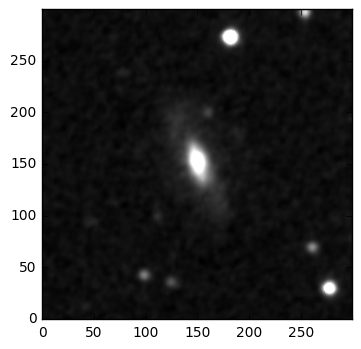

In [72]:
hdu_list=apfits.open(table.array['URL'][4])
plt.imshow(hdu_list[0].data, cmap='gray', origin='lower',vmax=0.1)

<div class="alert alert-block alert-danger">
Why does it so frequently time out?
</div>

### A related example with multiple VO interfaces
A very similar example uses the SkyView SIA protocol to retrieve an image from a different survey, SDSS, which is not held on the HEASARC SkyView server but at MAST.  In this case, the user is unaware of where the data come from, which is the point.  But under the hood, SkyView is using SIA to get the data from MAST.  

(Again, it will take a few seconds for the image to appear.)

In [73]:
params['survey']='sdssg'
r = requests.get('https://skyview.gsfc.nasa.gov/cgi-bin/vo/sia.pl', params=params)

In [75]:
vot=apvot.parse( io.StringIO( r.text) )
table = vot.get_first_table()
#fitslink=table.array['URL'][0]
#print fitslink
display(Image(url=table.array['URL'][1]))

<a id="tap1"></a>
# 3a. TAP:  Using the Table Access Protocol to find available VO resources

<a id="tap2"></a>
# 3b. TAP:  Using the TAP to cross-correlate our objects with a catalog

<a id="combo"></a>

# 4. Combining data from different catalogs

<a id="scs"></a>
# 5. SCS:  Using the Simple Cone Search to query a different catalog in a loop

<a id="ssa"></a>
# 6. SSA:  Using the Simple Spectral Access protocol to retrieve spectra.

<a id="example1"></a>
# Example 1:  Using Table Access Protocol

The __[IVOA TAP document](http://www.ivoa.net/documents/TAP/20100327/REC-TAP-1.0.html)__ describes the Table Access Protocol (TAP) that consist of an HTTP request to a given TAP service URL formed in a particular language (ADQL in this case) to specify what you wish to search for. 

## 1.1 A simple example to search a single catalog
Here, we will use a HEASARC catalog called 'zcat' that has columns including RA, DEC, and Bmag. The selection criteria match a single source.  

### Sending the query

In [ ]:
#  The requests package will convert human-readable parameters 
#  into the correct HTTP request format.  This is a generic utility,
#  and   
tap_params = {
    "request":"doQuery",
    "lang":"ADQL",
    "query":
    """SELECT * FROM zcat as cat where 
    cat.RA > 191. and cat.RA < 192 and cat.Dec > 30. and cat.Dec < 31 and cat.Bmag > 14.9"""
    }
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)


### Looking at the result

The response content is in XML in a VO Table standard:

In [ ]:
# To see the URL that requests constructed from the parameters given:
print r.url
### r.content returns type str while r.text returns type unicode.
#print r.content

### Reading the VO table object
(There will be warnings that can be ignored.)

In [ ]:

# Then we convert the resulting XML into a VOTable object.  This parse() expects a file,
#  so we use io.StringIO() to create a temporary "file-like" object from the 
#  XML text:
vot=votable.parse(io.StringIO(r.text))
### Since there could be multiple tables in the XML, 
table = vot.get_first_table()
table

## 1.2 Using TAP to find HEASARC services
In the above example, we knew the catalog we wanted, the 'zcat'.  This information is in a registry of VO services, which you can browse using the __[NAVO Directory](http://vao.stsci.edu/keyword-search/)__ and entering ID=nasa.heasarc.

But you can also find out what HEASARC services are available by querying the registry of services with TAP itself if you prefer. In this example, we will look for Simple Image Access (SIA) services. In this case, the resulting table (by construction in ADQL) contains only the name and description of the SIA service.  

In [ ]:
tap_params["query"]="""
    select distinct a.value,b.value
       from metainfo a, metainfo b
       where
         a.type='sialink' and a.relation='table' and
         b.type='table' and b.relation='description' and
         a.value=b.name
       order by a.value
       """
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
vot=votable.parse(io.StringIO(r.text))
table = vot.get_first_table()
table

There are similar ways to construct queries for different types of services, e.g., Simple Spectral Access (SIA) Protocol or Cone Search.  See below for examples.

<div class="alert alert-block alert-danger">
(Why isn't this the 88 from the NAVO Directory or SkyView?  What's the subset xamin sees?  I think it's only what TomM has gotten around to entering in the right place?)
</div>

<div class="alert alert-block alert-danger">
This would be useful to code as a function, e.g.,<br>
astroquery.heasarc.list_sia_services()<br>
though it should then include the skyview services instead/in addition?
</div>

<a id="example2"></a>
## Example 2:  Retrieving a HEASARC catalog as VOTable

<div class="alert alert-block alert-danger">
Maybe move this up?  First introduce VOTable format and the votable package?  then this example, and then the TAP access currently above?</div>

HEASARC's __[Browse](https://heasarc.gsfc.nasa.gov/cgi-bin/W3Browse/w3browse.pl)__ can be used interactively to output a VOTable formatted XML result.  It also has a simple VO interface that we can access using the standard python requests package, as in this example:  

(Note that this is fetching the entire 'rosmaster' catalog of 11k lines.  Give it a few seconds.)

<a id="example4"></a>
# Example 4:  HEASARC spectra retrieval
In addition to images, there are some spectra that can be retrieved from the HEASARC via the VO's Simple Spectral Access (SSA) Protocol. 

## 4.1 To see a list of available catalogs:
Currently, HEASARC has four catalogs that allow access to spectra through SSA.  

In [ ]:
tap_params["query"]="""
    select distinct a.value,b.value
       from metainfo a, metainfo b
       where
        a.type='ssalink' and a.relation='table' and
        b.type='table' and b.relation='description' and
        a.value=b.name
    order by a.value
    """
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
vot=votable.parse(io.StringIO(r.text))
table = vot.get_first_table()
table

<div class="alert alert-block alert-danger">
This would be useful as a function, e.g.,<br>
astroquery.heasarc.list_ssa_services()
</div>

## 4.2 We can then search for the available Chandra spectra in a given region:

In [ ]:
params = {'table': 'chanmaster',"POS":"187.27,2.05","SIZE":".01", "REQUEST":"queryData"}
r = requests.get('https://heasarc.nasa.gov/xamin/vo/ssa', params=params)
spec_vot=votable.parse(io.StringIO(r.text))
spec_table = spec_vot.get_first_table()

In [ ]:
for f in spec_table.fields:
        print f.ID

In [ ]:
print spec_table.array[0:3]['SSA_reference']

## 4.3  Download a spectrum and plot it:


In [ ]:
hdu_list=fits.open(spec_table.array[0]['SSA_reference'])
#hdu_list.info()
print hdu_list[1].columns
table = Table(hdu_list[1].data)
pha = plt.plot( table['CHANNEL'][8],table['COUNTS'][8])

<div class="alert alert-block alert-danger">
Better way to plot this?</div>

<a id="example5"></a>
# Example 5:  Search a cone
The __[Simple Cone Search (SCS) protocol](http://www.ivoa.net/documents/latest/ConeSearch.html)__ is used to search a given table with a given position and radius, getting again a VOTable XML result.  

## 5.1 Find SCS services for HEASARC
As above, first we use the TAP to find out what catalogs are available from HEASARC for cone searches:


In [ ]:
tap_params["query"]="""
    select a.name,b.value
      from metainfo a, metainfo b
      where
         a.type='table' and b.type='table' and
         a.relation='defaultSearchRadius' and
         b.relation='description' and
         a.name=b.name
      order by name    
      """
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params)
vot=votable.parse(io.StringIO(r.text))
table = vot.get_first_table()
table

## 5.2 Then perform a cone search on the catalog of interest:
In the case of a cone search, the standard specifies "RA", "DEC", "SR", etc. but not how the specific catalog/table is specified.  The normal way one does this is to query the registry and find the URL specific to the catalog, which in this case ends with something like "?table=zcat&".  For this example, we'll simply add that to the requests parameters.  

In [ ]:
params = {'table': 'zcat', 'RA': '9.90704', 'DEC':'8.96507', 'SR':'0.5'}
r = requests.get('https://heasarc.gsfc.nasa.gov/cgi-bin/vo/cone/coneGet.pl', params=params)
vot=votable.parse(io.StringIO(r.text))
table = vot.get_first_table()
table

<a id="pvo"></a>
# Example 6:  Using the TAP for cross-correlation with an uploaded table

First create a table following the example in http://docs.astropy.org/en/stable/io/votable/:

We can then hand this table to a service and reference it in the ADQL.  

In this simple example, we first run the above query that found all the soruces in a given region with a given magnitude from the zcat.   

In [ ]:
tap_params["query"]="""SELECT * FROM zcat as cat where cat.RA > 190. and cat.RA < 195 and cat.Dec > 30. and cat.Dec < 35 and cat.Bmag > 14.9"""
r = requests.get('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync', params=tap_params )
vot=votable.parse(io.StringIO(r.text))
table = vot.get_first_table()
table

The two sources in our custom-made table are simply two of these.  

We can then do a trivial cross-correlation between the zcat contents and our own table, in this case simply asking for the subset of sources above that happen to have names in our table:

In [ ]:
print tap_params

In [ ]:
## These are defined in the TAP standard:
cc_params={'lang': 'ADQL', 'request': 'doQuery','upload':'mytable,param:tab1'}
## This is your ADQL query, where "mytable" here has to match what you specified in the upload parameter 
cc_params["query"]="""SELECT * FROM zcat cat, tap_upload.mytable mt where cat.RA > 190. and cat.RA < 195 
    and cat.Dec > 30. and cat.Dec < 35 and cat.Bmag > 14.9 and cat.name = mt.name"""
## The name you give here (tab1) matches what's in the cc_params
files={'tab1':open('new_votable.xml', 'rb')}
r = requests.post('https://heasarc.gsfc.nasa.gov/xamin/vo/tap/sync',data=cc_params,files=files)
#r.text
vot=votable.parse(io.StringIO(r.text))
table = vot.get_first_table()
table

For a mores sophisticated example, we can use the ADQL function *contains* to find sources in rosmaster catalog that are within a specified distance from each source in the uploaded table.  